In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize

url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_card_customers.csv"
df = pd.read_csv(url)
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [ ]:
#Initial observations
print("Dataset dimensions:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

Dataset dimensions: (8950, 18)

Data types:
 CUST_ID                              object
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object

Missing values:
 CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES  

In [ ]:
#Descriptive statistical analysis
print("\nDescriptive statistics:\n", df.describe())


Descriptive statistics:
             BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      

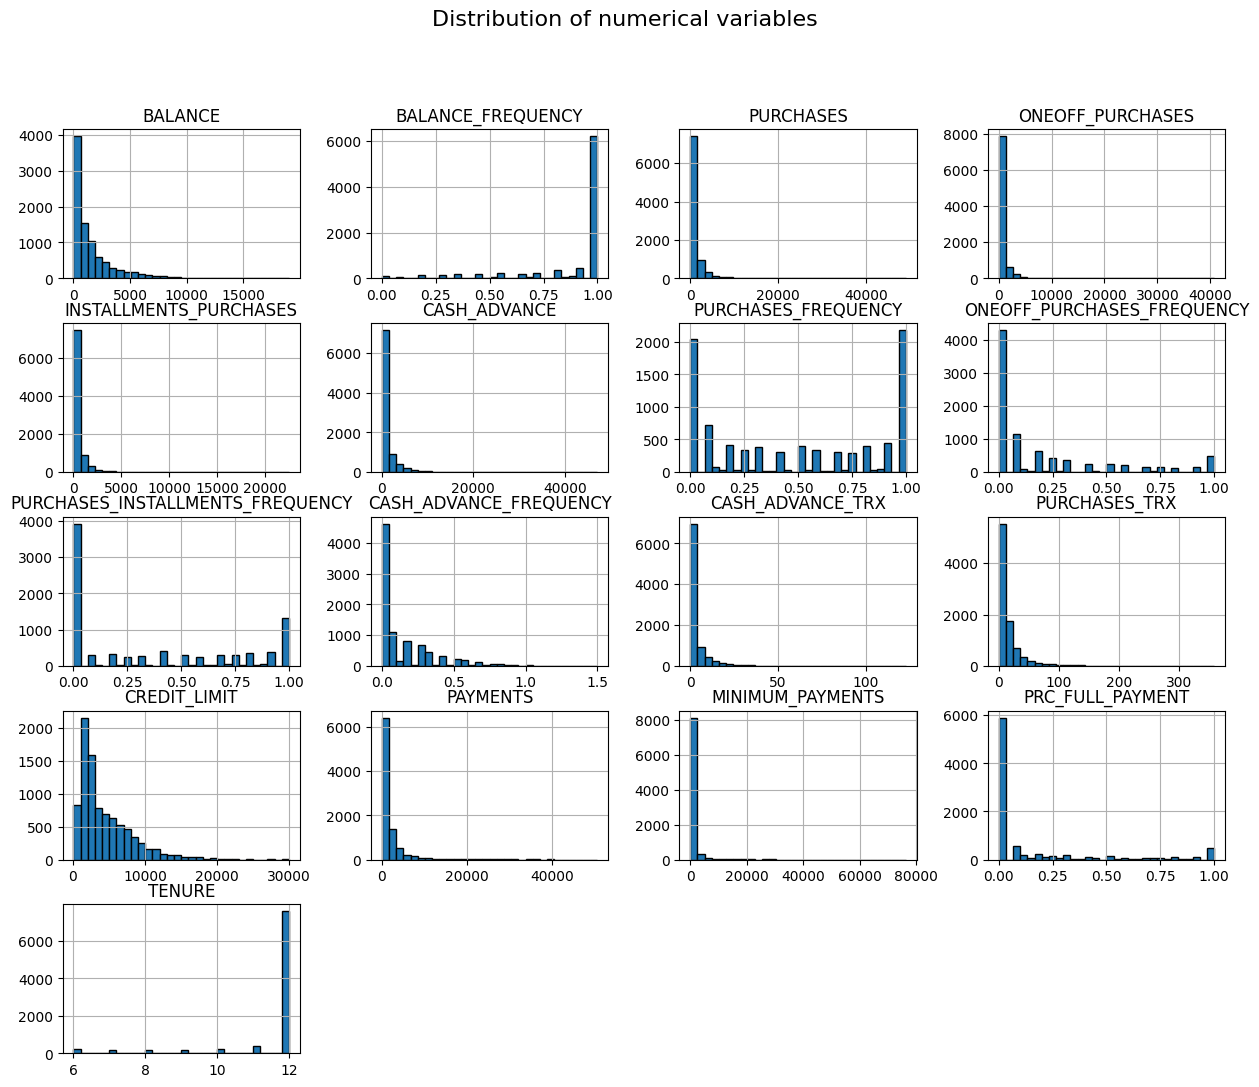

In [ ]:
#Visualizing the distribution of variables
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

#Histograms
df[numeric_columns].hist(figsize=(15, 12), bins=30, edgecolor='black')
plt.suptitle("Distribution of numerical variables", fontsize=16)
plt.show()

#Several features, such as BALANCE, PURCHASES, CASH_ADVANCE, PAYMENTS, show highly skewed distributions.


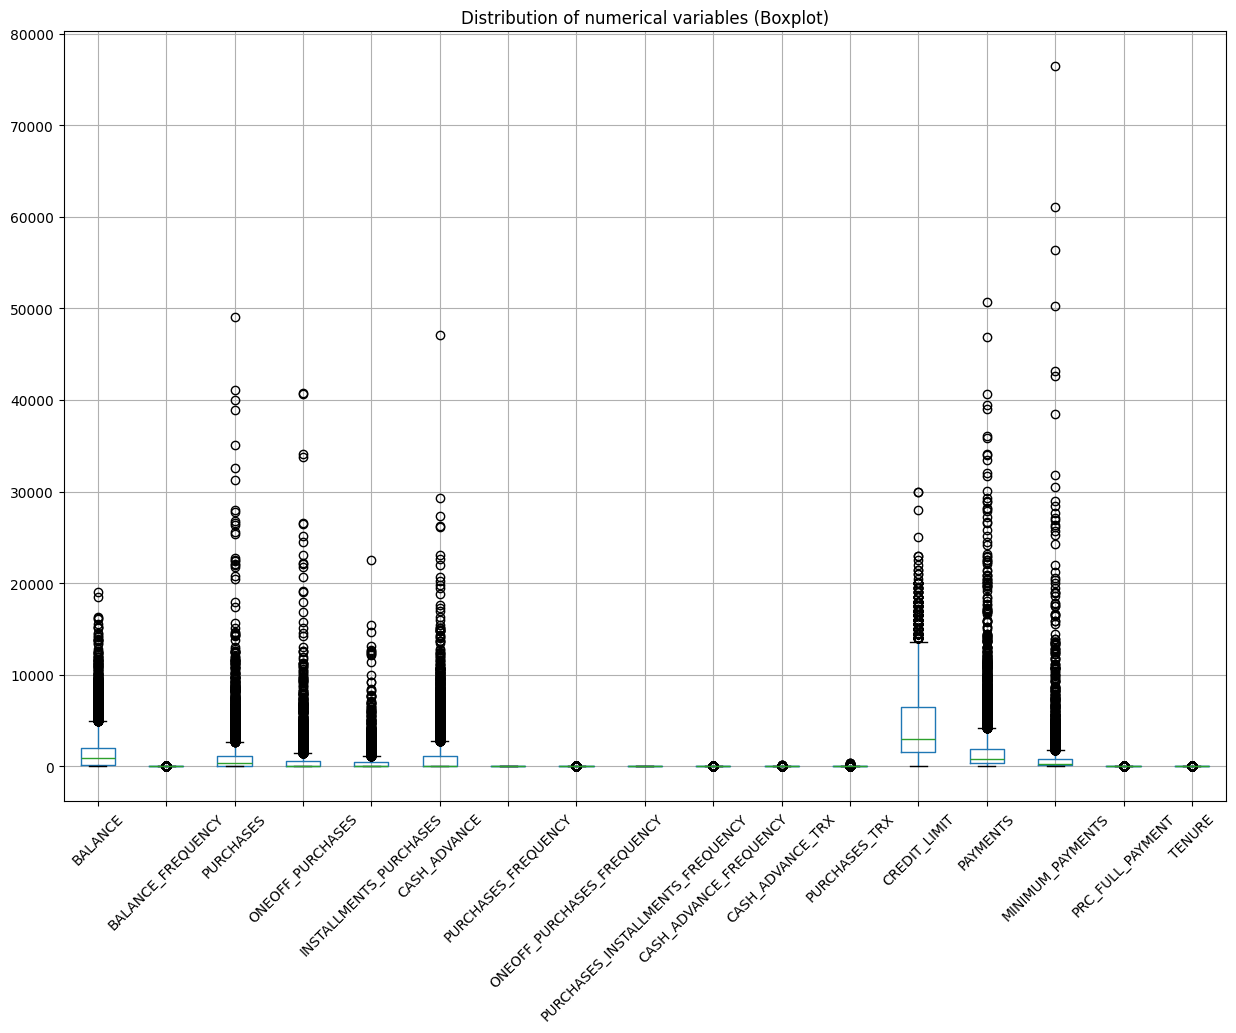

In [ ]:
#Boxplot to identify outliers
plt.figure(figsize=(15, 10))
df[numeric_columns].boxplot(rot=90)
plt.title("Distribution of numerical variables (Boxplot)")
plt.xticks(rotation=45)
plt.show()

#The boxplots indicate extreme values in multiple features, particularly BALANCE, PURCHASES, CASH_ADVANCE, MINIMUM PAYMENTS, PAYMENTS, CREDIT_LIMIT

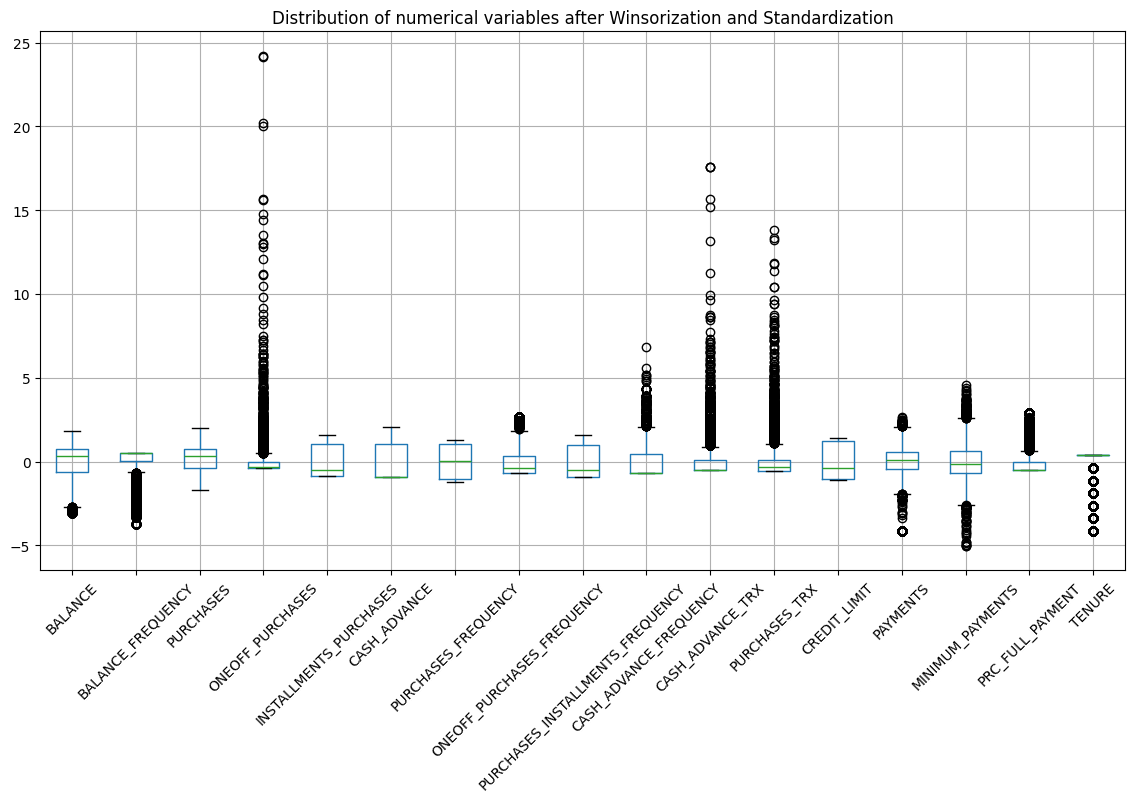

In [ ]:
#Handling missing values
df["MINIMUM_PAYMENTS"] = df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].median())



# 3. Treatment of outliers with Winsorization (20% for identified columns).
outlier_cols = ["INSTALLMENTS_PURCHASES", "CREDIT_LIMIT"]
df[outlier_cols] = df[outlier_cols].apply(lambda x: winsorize(x, limits=[0.2, 0.2]))

# 4. Logarithmic transformation for strongly skewed variables
skewed_cols = ["BALANCE", "PURCHASES", "CASH_ADVANCE", "PAYMENTS", "MINIMUM_PAYMENTS"]
df[skewed_cols] = df[skewed_cols].apply(lambda x: np.log1p(x))

# 5. Normalization of features (StandardScaler on numeric columns)
numeric_cols = df.select_dtypes(include=[np.number]).columns  # Selects only numeric columns
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])  # Normalizes only numeric columns

# 6. Visualization of distributions after Winsorization and Standardization
plt.figure(figsize=(14, 7))
df[numeric_cols].boxplot(rot=45)
plt.title("Distribution of numerical variables after Winsorization and Standardization")
plt.show()



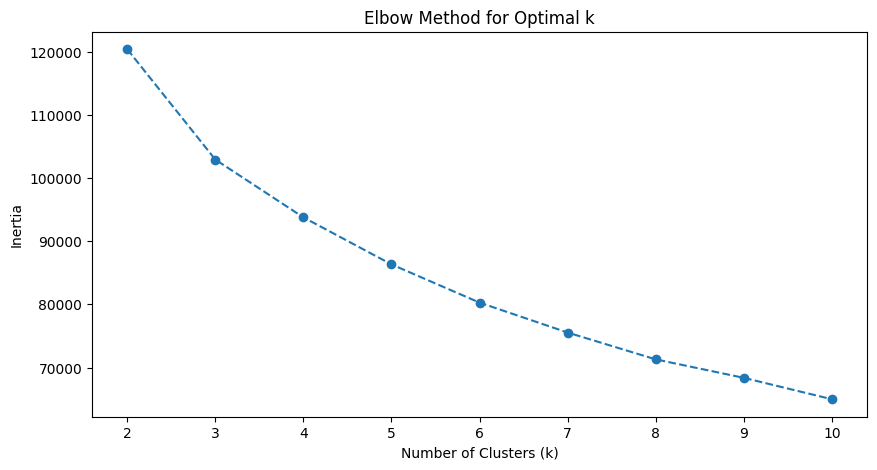

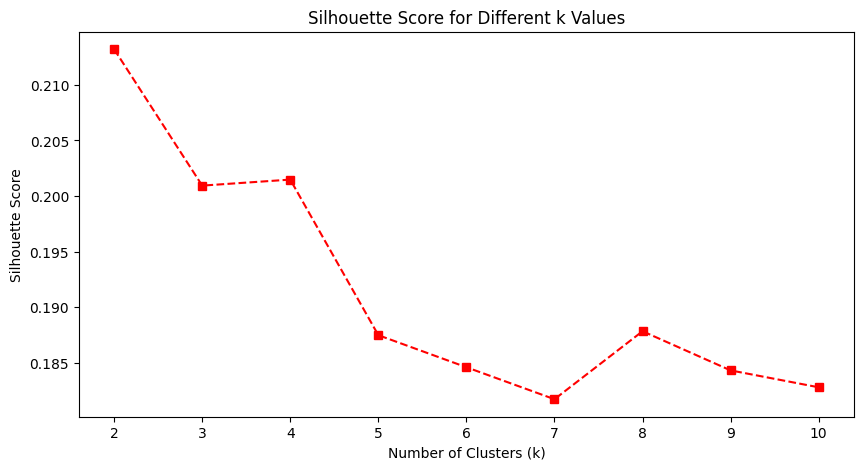

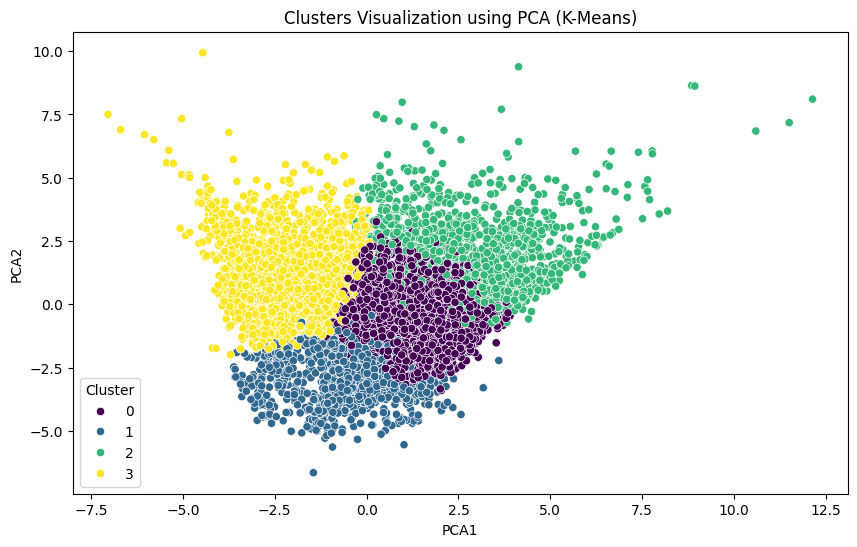

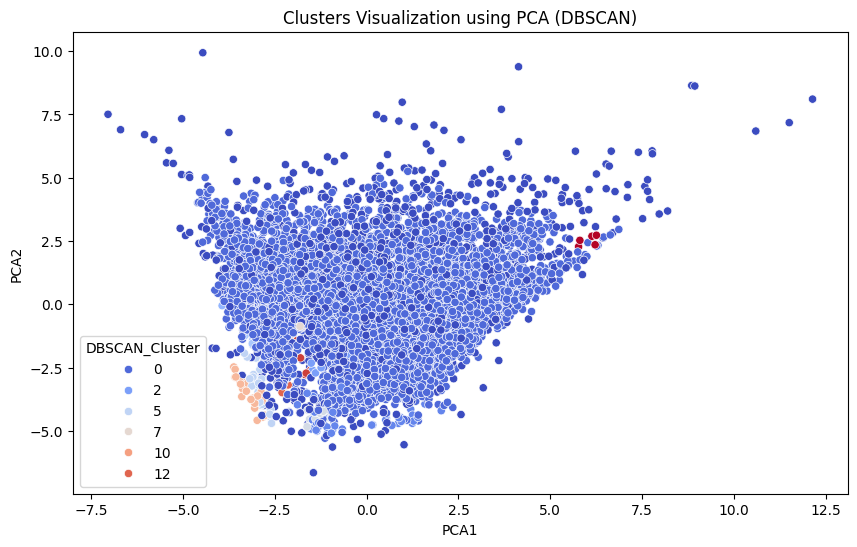

In [ ]:
# 1. Define the range of clusters for K-Means
K_range = range(2, 11)  # Trying k from 2 to 10
inertia = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df[numeric_cols])
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df[numeric_cols], kmeans.labels_))


# 2. Elbow Method to determine the optimal number of clusters
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()
#The Elbow Method helps find the optimal number of clusters by identifying the "elbow point" where inertia stops decreasing significantly
#The inertia (sum of squared distances from each point to its assigned cluster center) decreases as k increases.
#The "elbow" point, where the decrease slows down significantly, appears around k=4.
#This suggests that adding more clusters beyond this point results in diminishing returns in terms of inertia reduction



# 3. Silhouette Score Analysis
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, marker='s', linestyle='--', color='r')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different k Values")
plt.show()
#The Silhouette Score measures how well-separated the clusters are. A higher score indicates better-defined clusters.
#The silhouette score is highest at k=2, but choosing k=2 may result in overly simplistic clustering.
#Since k=4 maintains a reasonable score before further decline, it suggests that clusters remain distinct enough.



# 4. Fit the final K-Means model using the optimal k (e.g., k=4)
optimal_k = 4  # Choose based on Elbow & Silhouette analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df[numeric_cols])


# 5. Applying DBSCAN for comparison
dbscan = DBSCAN(eps=1.5, min_samples=5)
df["DBSCAN_Cluster"] = dbscan.fit_predict(df[numeric_cols])

# 6. PCA for 2D visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[numeric_cols])
df["PCA1"] = df_pca[:, 0]
df["PCA2"] = df_pca[:, 1]
#PCA (Principal Component Analysis) reduces the data to 2 dimensions for visualization.


plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue=df["Cluster"], palette="viridis", data=df)
plt.title("Clusters Visualization using PCA (K-Means)")
plt.show()
#The clusters are well-separated when visualized in 2D using PCA.
#The color-coded regions suggest that K-Means effectively segmented the data.


plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue=df["DBSCAN_Cluster"], palette="coolwarm", data=df)
plt.title("Clusters Visualization using PCA (DBSCAN)")
plt.show()
#The visualization suggests that the dataset contains both well-defined clusters and scattered noise points.





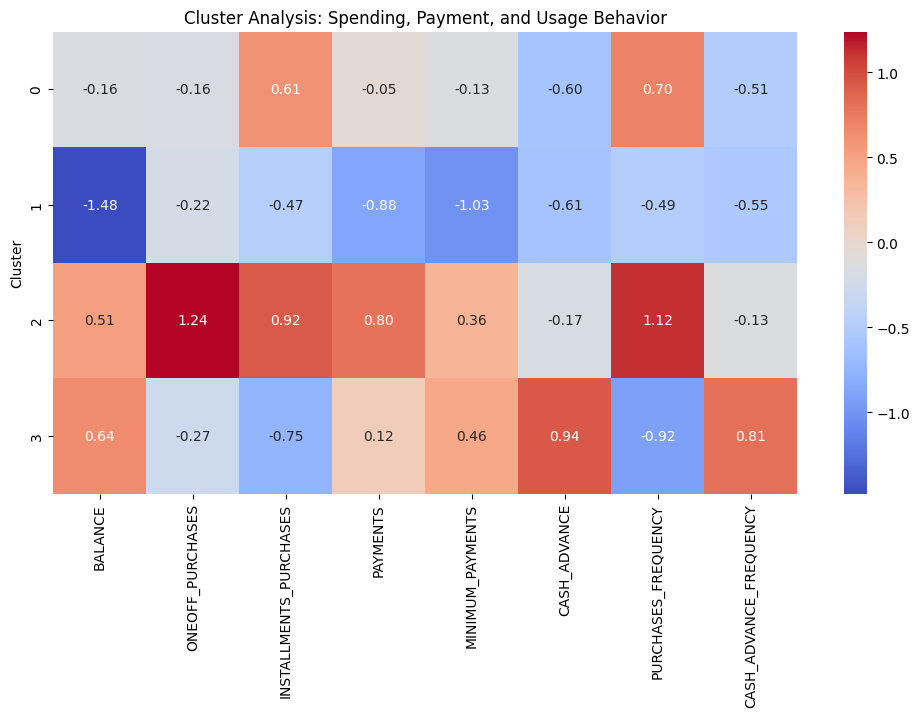

          BALANCE  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  PAYMENTS  \
Cluster                                                                 
0       -0.159516         -0.162612                0.605963 -0.045817   
1       -1.476992         -0.222801               -0.473009 -0.877287   
2        0.512046          1.240437                0.923093  0.802114   
3        0.638741         -0.269025               -0.752147  0.118956   

         MINIMUM_PAYMENTS  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                        
0               -0.134627     -0.600370             0.700243   
1               -1.027596     -0.607600            -0.487569   
2                0.362862     -0.173040             1.121029   
3                0.464282      0.941051            -0.920624   

         CASH_ADVANCE_FREQUENCY  
Cluster                          
0                     -0.505489  
1                     -0.551065  
2                     -0.132742  
3     

In [ ]:
# 1. Define key financial behavior categories
spending_features = ["BALANCE", "ONEOFF_PURCHASES", "INSTALLMENTS_PURCHASES"]
payment_features = ["PAYMENTS", "MINIMUM_PAYMENTS"]
usage_features = ["CASH_ADVANCE", "PURCHASES_FREQUENCY", "CASH_ADVANCE_FREQUENCY"]

# 2. Calculate the mean values for each cluster
cluster_analysis = df.groupby("Cluster")[spending_features + payment_features + usage_features].mean()

# 3. Visualize cluster characteristics
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_analysis, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Cluster Analysis: Spending, Payment, and Usage Behavior")
plt.show()

# 4. Print numerical summary
print(cluster_analysis)


In [ ]:
#Results:

"""Cluster 0 – Moderate Users with Regular Payments
Spending: These customers tend to make installment purchases (+0.61) but do not spend much in one-time purchases (-0.16).
Payments: They have an average payment level (-0.05) and do not rely heavily on minimum payments (-0.13).
Card Usage: They use their credit cards frequently (+0.70) but avoid cash advances (-0.60).
Possible Interpretation: Regular customers who prefer installment payments but maintain responsible financial management.

Cluster 1 – Low Usage Customers with Payment Difficulties
Spending: They have the lowest balance (-1.48) and spend little on both one-time purchases (-0.22) and installment purchases (-0.47).
Payments: They make fewer payments (-0.88) and rarely pay even the minimum amount (-1.03).
Card Usage: Their card usage is low (-0.49), and they also avoid cash advances (-0.61).
Possible Interpretation: Customers who may be experiencing financial difficulties or simply do not use their credit cards frequently.


Cluster 2 – High Spenders with Active Payments
Spending: They spend a lot on both one-time purchases (+1.24) and installment purchases (+0.92).
Payments: They make large payments (+0.80) and do not struggle with minimum payments (+0.36).
Card Usage: They use their credit cards very frequently (+1.12) but do not rely on cash advances (-0.17).
Possible Interpretation: Customers with high spending capacity and strong financial management.


Cluster 3 – Customers Who Rely on Cash Advances
Spending: They have a high balance (+0.64) but spend little on one-time purchases (-0.27) and even less on installments (-0.75).
Payments: They make moderate payments (+0.12) but rely more on minimum payments (+0.46).
Card Usage: They have a low purchase frequency (-0.92) but use cash advances frequently (+0.81).
Possible Interpretation: Customers who depend on cash advances, potentially indicating a higher financial risk."""

In [ ]:
#5.Marketing strategies:

"""
CLUSTER 0 - Marketing Strategies
- Offer financing with preferential interest rates on specific products.
- Establish partnerships with stores to provide discounts or cashback on purchases made in installments with the card.
- Propose personal loans or credit cards with better conditions to increase customer loyalty.


CLUSTER 1 - Marketing Strategies
- Provide webinars or guides on optimizing credit card usage to improve financial stability.
- Encourage full balance payments by offering small cashback incentives or reducing interest rates.


CLUSTER 2 - Marketing Strategies
- Offer progressive cashback based on monthly spending or loyalty points redeemable for travel, exclusive experiences, or gift cards.
- Propose credit cards with additional benefits such as travel insurance, priority assistance, or higher spending limits.


CLUSTER 3 - Marketing Strategies
- Develop special offers on credit cards with better conditions for customers requiring frequent cash advances.
- Suggest more efficient alternatives to cash advances, such as installment payments or short-term financing products."""





